In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#load data item_proprties_part1 and item_proprties_part2 and concatenate them into one dataset
df_item_properties_part1 = pd.read_csv('item_properties_part1.1.csv', index_col=None)
df_item_properties_part2 = pd.read_csv('item_properties_part2.csv', index_col=None)
df_item_properties = pd.concat([df_item_properties_part1, df_item_properties_part2], ignore_index=True)
df_item_properties.head()

,timestamp,itemid,property,value
0,1.435460e+12,460429,categoryid,1338
1,1.441510e+12,206783,888,1116713 960601 n277.200
2,1.439090e+12,395014,400,n552.000 639502 n720.000 424566
3,1.431230e+12,59481,790,n15360.000
4,1.431830e+12,156781,917,828513


In [3]:
# load behaviour events dataset
df_events = pd.read_csv('events.csv', index_col=None)
df_events.head()

,timestamp,visitorid,event,itemid,transactionid
0,1.433220e+12,257597,view,355908,NaN
1,1.433220e+12,992329,view,248676,NaN
2,1.433220e+12,111016,view,318965,NaN
3,1.433220e+12,483717,view,253185,NaN
4,1.433220e+12,951259,view,367447,NaN


In [4]:
# load category tree dataset
df_category_tree = pd.read_csv('category_tree.csv')
df_category_tree.head()

,categoryid,parentid
0,1016,213.0
1,809,169.0
2,570,9.0
3,1691,885.0
4,536,1691.0


In [5]:
#shape of the data sets
df_item_properties.shape

(2097150, 4)

In [6]:
df_events.shape

(1048575, 5)

In [7]:
df_category_tree.shape

(1669, 2)

### Clean the item_properties dataset

In [8]:
def decode_value(row):
    prop = row['property']
    val = str(row['value'])

    # Rule 1: If property == available
    if prop == 'available':
        return val
    
    # Rule 2: If property == categoryid
    if prop == 'categoryid':
        return val

    # Rule 3: Otherwise, extract numbers starting with 'n'
    nums = []
    for part in val.split():
        if part.startswith('n'):
            try:
                nums.append(float(part[1:]))  # remove 'n' and convert
            except ValueError:
                pass

    if len(nums) == 0:
        return np.nan
    elif len(nums) == 1:
        return nums[0]
    else:
        return sum(nums) / len(nums)  # average

# Apply the function to create the new column
df_item_properties['decoded_value'] = df_item_properties.apply(decode_value, axis=1)

df_item_properties

,timestamp,itemid,property,value,decoded_value
0,1.435460e+12,460429,categoryid,1338,1338
1,1.441510e+12,206783,888,1116713 960601 n277.200,277.2
2,1.439090e+12,395014,400,n552.000 639502 n720.000 424566,636.0
3,1.431230e+12,59481,790,n15360.000,15360.0
4,1.431830e+12,156781,917,828513,NaN
...,...,...,...,...,...
2097145,1.438480e+12,375432,categoryid,1561,1561
2097146,1.433650e+12,31766,888,1194687 550565 877590,NaN
2097147,1.431230e+12,186906,283,305351 1031524 787418,NaN
2097148,1.433650e+12,83658,797,115592,NaN


### Convert timestamp to human readable format and drop Value column

In [10]:
df_item_properties['timestamp'] = pd.to_datetime(df_item_properties['timestamp'], unit='ms')

In [11]:
df_item_properties = df_item_properties.drop(columns=['value'])

In [14]:
# sort by timestamp
df_item_properties = df_item_properties.sort_values(by='timestamp')
df_item_properties = df_item_properties.drop_duplicates(subset=['itemid', 'property'], keep='last')
df_item_properties.shape

(1403957, 4)

### clean event dataset by making timestamp readable

In [15]:
# timestamp to readable format
df_events['timestamp'] = pd.to_datetime(df_events['timestamp'], unit='ms')
df_events.head()

,timestamp,visitorid,event,itemid,transactionid
0,2015-06-02 04:40:00,257597,view,355908,NaN
1,2015-06-02 04:40:00,992329,view,248676,NaN
2,2015-06-02 04:40:00,111016,view,318965,NaN
3,2015-06-02 04:40:00,483717,view,253185,NaN
4,2015-06-02 04:40:00,951259,view,367447,NaN


### Clean category tree dataset

In [16]:
parent_map = dict(zip(df_category_tree['categoryid'], df_category_tree['parentid']))

# Step 2: Function to recursively get the full path as a list
def get_category_path_list(cat_id, parent_map):
    path = [cat_id]
    while cat_id in parent_map and not pd.isna(parent_map[cat_id]):
        cat_id = parent_map[cat_id]
        path.append(cat_id)
    return path  # Keep as list

# Step 3: Apply to each category
df_category_tree['category_path'] = df_category_tree['categoryid'].apply(lambda x: get_category_path_list(x, parent_map))

df_category_tree.head()

,categoryid,parentid,category_path
0,1016,213.0,"[1016, 213.0, 1299.0, 1532.0]"
1,809,169.0,"[809, 169.0, 1257.0, 395.0]"
2,570,9.0,"[570, 9.0, 351.0, 653.0]"
3,1691,885.0,"[1691, 885.0, 1579.0]"
4,536,1691.0,"[536, 1691.0, 885.0, 1579.0]"


### merge item_properties and event tables

In [17]:
df_props_events = pd.merge(df_item_properties, df_events, on='itemid', how='inner')
df_props_events.head()

,timestamp_x,itemid,property,decoded_value,timestamp_y,visitorid,event,transactionid
0,2015-05-10 03:53:20,376515,888,9613356.0,2015-06-04 17:46:40,716335,view,NaN
1,2015-05-10 03:53:20,376515,888,9613356.0,2015-06-23 17:20:00,878164,view,NaN
2,2015-05-10 03:53:20,376515,888,9613356.0,2015-06-25 02:40:00,713750,view,NaN
3,2015-05-10 03:53:20,376515,888,9613356.0,2015-08-12 00:40:00,213467,view,NaN
4,2015-06-14 02:46:40,376515,964,NaN,2015-06-04 17:46:40,716335,view,NaN


In [18]:
df_props_events.shape

(3623547, 8)

In [19]:
df_props_events.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3623547 entries, 0 to 3623546
Data columns (total 8 columns):
 #   Column         Dtype         
---  ------         -----         
 0   timestamp_x    datetime64[ns]
 1   itemid         int64         
 2   property       object        
 3   decoded_value  object        
 4   timestamp_y    datetime64[ns]
 5   visitorid      int64         
 6   event          object        
 7   transactionid  float64       
dtypes: datetime64[ns](2), float64(1), int64(2), object(3)
memory usage: 248.8+ MB


In [20]:
df_props_events.isna().sum()

timestamp_x            0
itemid                 0
property               0
decoded_value    2426005
timestamp_y            0
visitorid              0
event                  0
transactionid    3590955
dtype: int64

### change data types for the following columns; itemid, decoded_value, visitorid, transactionid

In [22]:
### change decoded_value datatype
df_props_events['decoded_value'] = pd.to_numeric(df_props_events['decoded_value'], errors='coerce')
df_props_events['itemid'] = df_props_events['itemid'].astype('int64').astype(str)
df_props_events['transactionid'] = df_props_events['transactionid'].astype('float64').astype(str)
df_props_events['visitorid'] = df_props_events['visitorid'].astype('int64').astype(str)
df_props_events.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3623547 entries, 0 to 3623546
Data columns (total 8 columns):
 #   Column         Dtype         
---  ------         -----         
 0   timestamp_x    datetime64[ns]
 1   itemid         object        
 2   property       object        
 3   decoded_value  float64       
 4   timestamp_y    datetime64[ns]
 5   visitorid      object        
 6   event          object        
 7   transactionid  object        
dtypes: datetime64[ns](2), float64(1), object(5)
memory usage: 248.8+ MB


## Business Questions

### 1. What are the top 10 items that received the most view events ?

In [25]:
# Filter for 2015 full year and event = 'view'
filtered_df_props_events = df_props_events[
    (df_props_events['timestamp_y'] >= '2015-01-01') &
    (df_props_events['timestamp_y'] <= '2015-12-31') &
    (df_props_events['event'] == 'view')
]

# Group by itemid and count views
item_view_counts = (
    filtered_df_props_events.groupby('itemid')
    .size()
    .reset_index(name='view_count')
)

# Get the top 10
top10_items = item_view_counts.sort_values('view_count', ascending=False).head(10)

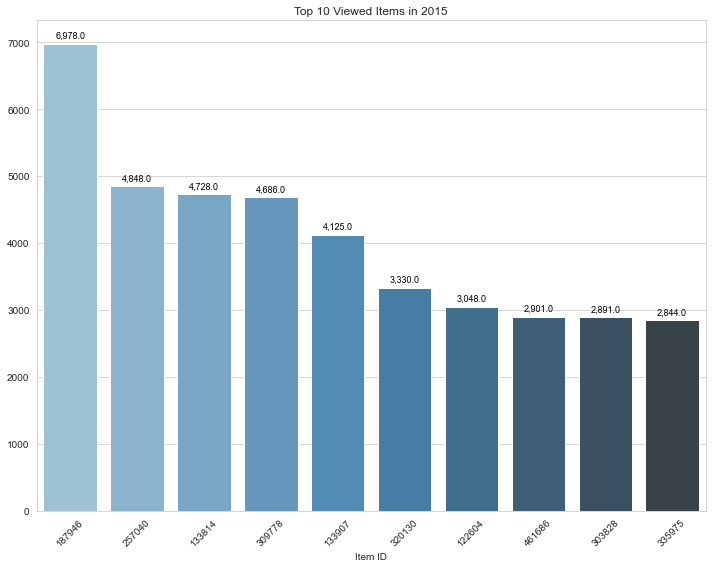

In [26]:
sns.set_style("whitegrid")

plt.figure(figsize=(10, 8))
ax = sns.barplot(
    data=top10_items,
    x='itemid',
    y='view_count',
    palette='Blues_d'
)


ax.set_ylabel(None)


for p in ax.patches:
    ax.annotate(
        format(p.get_height(), ','),
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center', va='center',
        xytext=(0, 8),
        textcoords='offset points',
        fontsize=9,
        color='black'
    )


ax.set_xlabel('Item ID')
ax.set_title('Top 10 Viewed Items in 2015')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

In [30]:
df_props_events['event'].unique()

array(['view', 'transaction', 'addtocart'], dtype=object)

### What are the top 10 items that received the most Add to Cart events ?

In [33]:
# Filter for 2015 full year and event = 'addtocart'
filtered_df_props_events = df_props_events[
    (df_props_events['timestamp_y'] >= '2015-01-01') &
    (df_props_events['timestamp_y'] <= '2015-12-31') &
    (df_props_events['event'] == 'addtocart')
]

# Group by itemid and count addtocart
item_addtocart_counts = (
    filtered_df_props_events.groupby('itemid')
    .size()
    .reset_index(name='addtocart_count')
)

# Get the top 10
top10_addtocart_items = item_addtocart_counts.sort_values('addtocart_count', ascending=False).head(10)

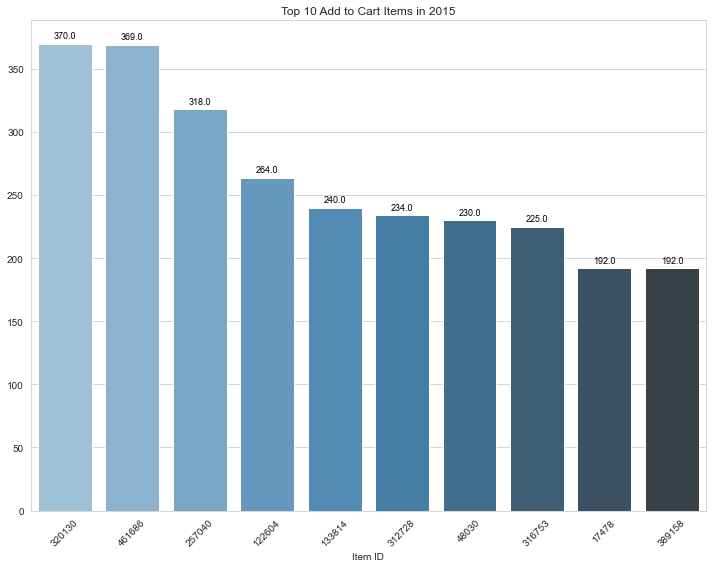

In [32]:
sns.set_style("whitegrid")

plt.figure(figsize=(10, 8))
ax = sns.barplot(
    data=top10_addtocart_items,
    x='itemid',
    y='addtocart_count',
    palette='Blues_d'
)


ax.set_ylabel(None)


for p in ax.patches:
    ax.annotate(
        format(p.get_height(), ','),
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center', va='center',
        xytext=(0, 8),
        textcoords='offset points',
        fontsize=9,
        color='black'
    )


ax.set_xlabel('Item ID')
ax.set_title('Top 10 Add to Cart Items in 2015')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()